In [1]:
model1name = "Palma2021"
model2name = "Ikonomi2020"

In [2]:
import ginsim
import biolqm
import maboss
import pypint
import numpy as np
import pandas as pd
from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations  # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
from scipy.stats import pearsonr # for calculating the pearson correlation
from rpy2.robjects.packages import importr
from rpy2.robjects import IntVector
from rpy2.robjects.vectors import ListVector
from rpy2 import robjects
from rpy2.robjects import conversion
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
boolnet = importr("BoolNet")
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler

This notebook has been executed using the docker image `colomoto/colomoto-docker:2024-03-01`

In [4]:
def simulation(model_file):
    model = biolqm.load(model_file)
    
    # set the fix value for the simulations
    wt = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%1")
    flt3 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%1")
    npm1 = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%0")
    dnmt3a = biolqm.perturbation(model, "FLT3%0 DNMT3A%0 NPM1%1")
    npm1_dnmt3a = biolqm.perturbation(model,"FLT3%0 DNMT3A%0 NPM1%0")
    flt3_dnmt3a = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%1")
    flt3_npm1 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%0")
    flt3_npm1_dnmt3a = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%0")

    # get the stable states
    networks = [wt,flt3,npm1,dnmt3a,npm1_dnmt3a,flt3_dnmt3a,flt3_npm1,flt3_npm1_dnmt3a]
    results = pd.DataFrame()
    for network in networks:
        fps = biolqm.fixpoints(network)
        # take average if multiple stable states exist
        results = pd.concat([results, pd.DataFrame(fps).mean().to_frame().T],ignore_index=True)
    results.index = ["NONE", "FLT3", "NPM1", "DNMT3A", "NPM1_DNMT3A", "FLT3_DNMT3A", "FLT3_NPM1", "FLT3_NPM1_DNMT3A"]
    simulation_results = results.T.sort_index()
    return simulation_results

simulation_results_1 = simulation ('./Models/' + model1name + '.sbml')
# simulation_results_2 = simulation ('./Models/' + model2name + '.sbml')
simulation_results_and = simulation ("./Models/merged_and_" + model1name + "_" + model2name + '.sbml')
simulation_results_inhibitor_wins = simulation ("./Models/merged_inhibitor_wins_" + model1name + "_" + model2name + '.sbml')
simulation_results_or = simulation ("./Models/merged_or_" + model1name + "_" + model2name + '.sbml')

In [ ]:
expression = pd.read_csv("./Data/BeatAML/beataml_waves1to4_norm_exp_dbgap.txt", sep='\t')
mapping = pd.read_excel("./Data/BeatAML/beataml_waves1to4_sample_mapping.xlsx")
mutations = pd.read_csv("./Data/BeatAML/beataml_wes_wv1to4_mutations_dbgap.txt", sep='\t')
genes_of_interest = {'FLT3', 'NPM1', 'DNMT3A'}

# Group by sample ID and collect the mutated genes into a list
mutations_grouped = mutations.groupby('dbgap_sample_id')['symbol'].agg(set).reset_index()

# Classification function
def classify_mutations(mutation_set):
    intersection = mutation_set.intersection(genes_of_interest)
    if not intersection:
        return 'NONE'
    else:
        return '_'.join(sorted(intersection)).upper()

# Apply classification
mutations_grouped['category'] = mutations_grouped['symbol'].apply(classify_mutations)

# Output sample IDs by category
categories = ["NONE", "FLT3", "NPM1", "DNMT3A", "NPM1_DNMT3A", "FLT3_DNMT3A", "FLT3_NPM1", "FLT3_NPM1_DNMT3A"]
output = {category: mutations_grouped[mutations_grouped['category'] == category]['dbgap_sample_id'].tolist() for category in categories}

# Map dbgap_sample_ids to their corresponding dbgap_rnaseq_samples and remove NaNs
mapping_results = {}
for category, samples in output.items():
    # Filter mapping dataframe for samples that are in the current category's sample list
    filtered_mapping = mapping[mapping['dbgap_dnaseq_sample'].isin(samples)]
    # Extract the corresponding dbgap_rnaseq_samples and remove NaNs
    corresponding_rna_samples = filtered_mapping['dbgap_rnaseq_sample'].dropna().tolist()
    # Store in results dictionary
    mapping_results[category] = corresponding_rna_samples

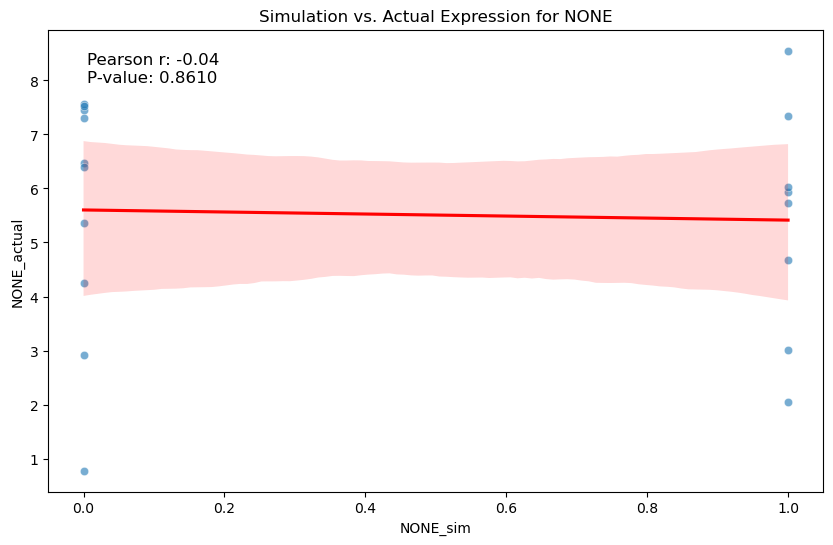

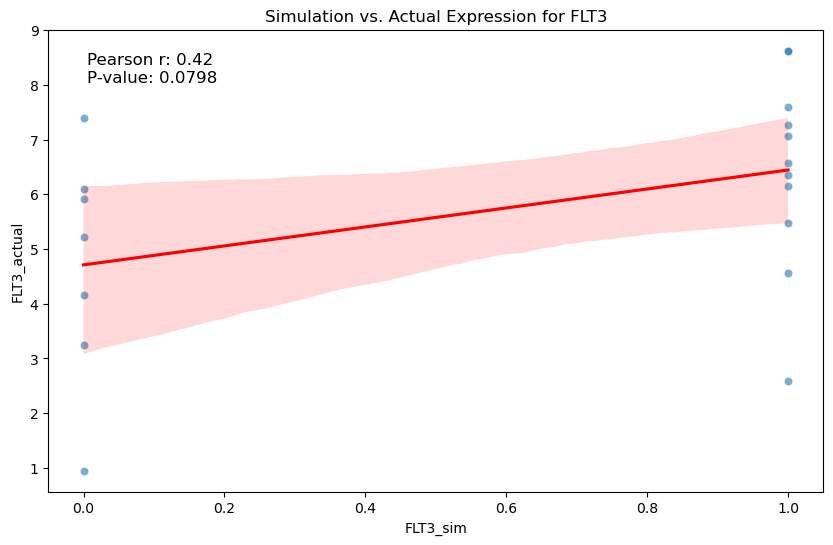

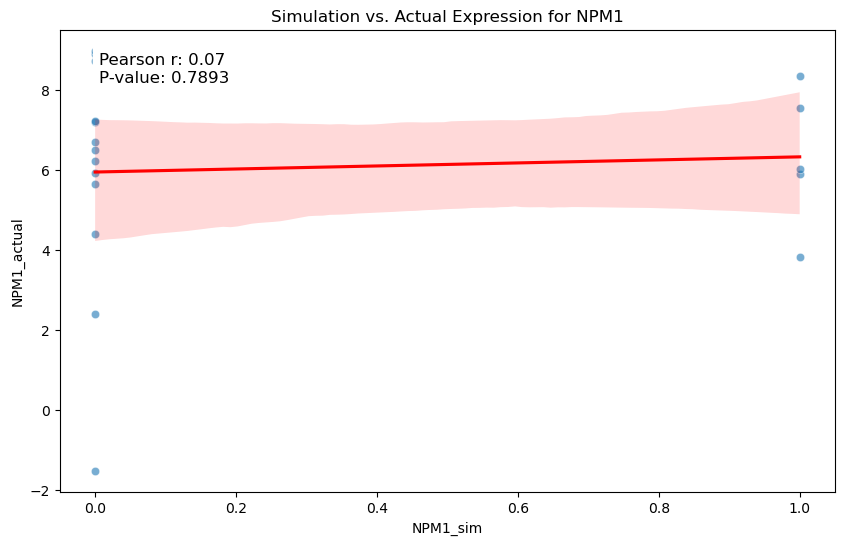

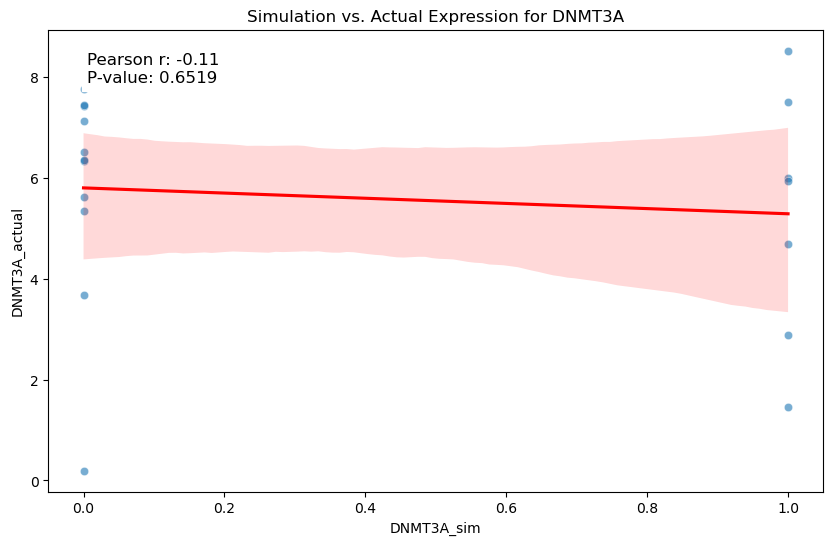

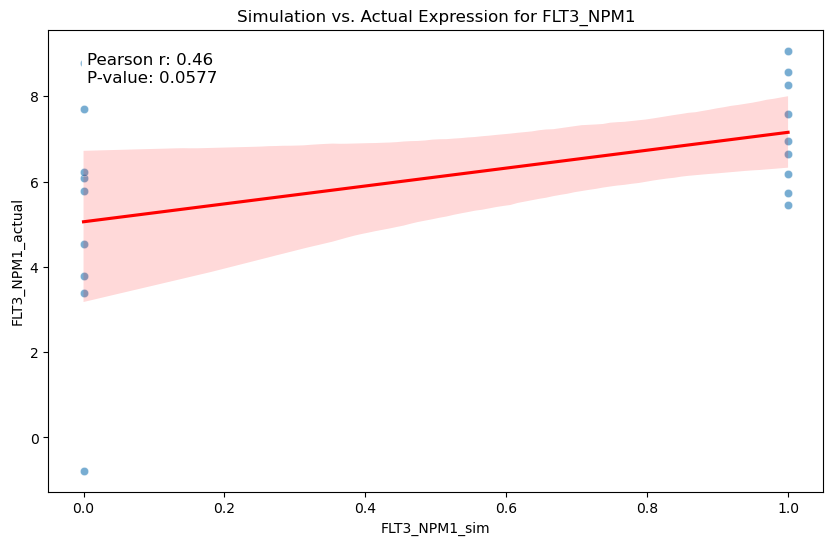

In [8]:
def compare_simulation_with_expression(simulation_df, expression_df, results_mapping):
    # Ensure all data in simulation_df is numeric
    simulation_df = simulation_df.apply(pd.to_numeric, errors='coerce')
    
    # Reshape expression_df to long format
    expression_long = expression_df.melt(id_vars=['display_label'], var_name='sample', value_name='expression')
    
    # Create a mapping of sample to condition from results_mapping
    sample_to_condition = {}
    for condition, samples in results_mapping.items():
        for sample in samples:
            sample_to_condition[sample] = condition
    
    # Map samples to conditions in expression_long
    expression_long['condition'] = expression_long['sample'].map(sample_to_condition)
    
    # Drop rows where condition is NaN (samples that don't map to any condition)
    expression_long.dropna(subset=['condition'], inplace=True)
    
    # Aggregate expression data by gene and condition
    average_expression = expression_long.groupby(['display_label', 'condition']).expression.mean().unstack()

    # Merge with simulation data 
    combined_data = simulation_df.join(average_expression, how='inner', lsuffix='_sim', rsuffix='_actual')

    # Ensure all data used for correlation and plotting are numeric and drop NaNs
    combined_data = combined_data.apply(pd.to_numeric, errors='coerce').dropna()

    # Plotting
    conditions = simulation_df.columns
    for condition in conditions:
        if condition + '_actual' in combined_data:
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=combined_data[condition + '_sim'], y=combined_data[condition + '_actual'], alpha=0.6)
            plt.title(f"Simulation vs. Actual Expression for {condition}")
            plt.xlabel('Simulated Expression')
            plt.ylabel('Actual Expression')

            # Fit linear regression and calculate Pearson correlation
            if combined_data[condition + '_sim'].notna().any() and combined_data[condition + '_actual'].notna().any():
                coef, p_value = pearsonr(combined_data[condition + '_sim'].dropna(), combined_data[condition + '_actual'].dropna())
                sns.regplot(x=combined_data[condition + '_sim'], y=combined_data[condition + '_actual'], scatter=False, color='red')

                plt.annotate(f'Pearson r: {coef:.2f}\nP-value: {p_value:.4f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                             horizontalalignment='left', verticalalignment='top', fontsize=12, backgroundcolor='white')
            else:
                plt.annotate('Insufficient data for correlation', xy=(0.05, 0.95), xycoords='axes fraction', 
                             horizontalalignment='left', verticalalignment='top', fontsize=12, backgroundcolor='white')
            plt.show()

compare_simulation_with_expression(simulation_results_1, expression, mapping_results)

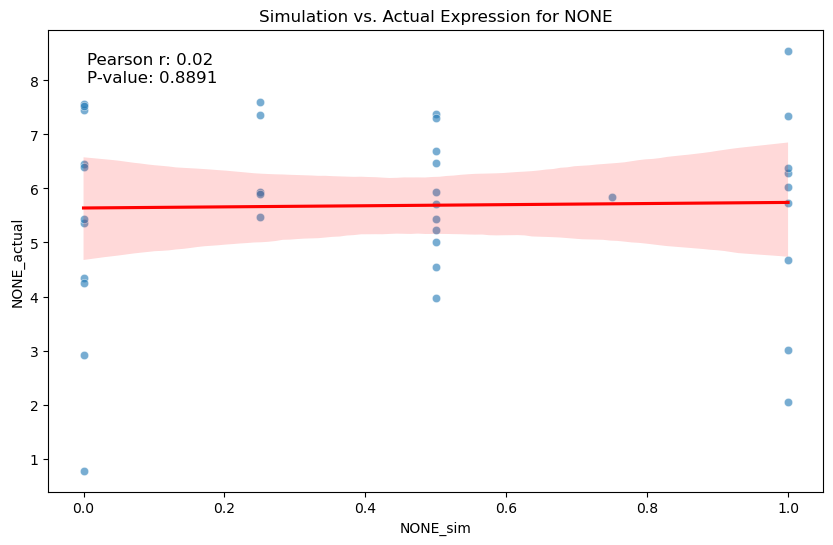

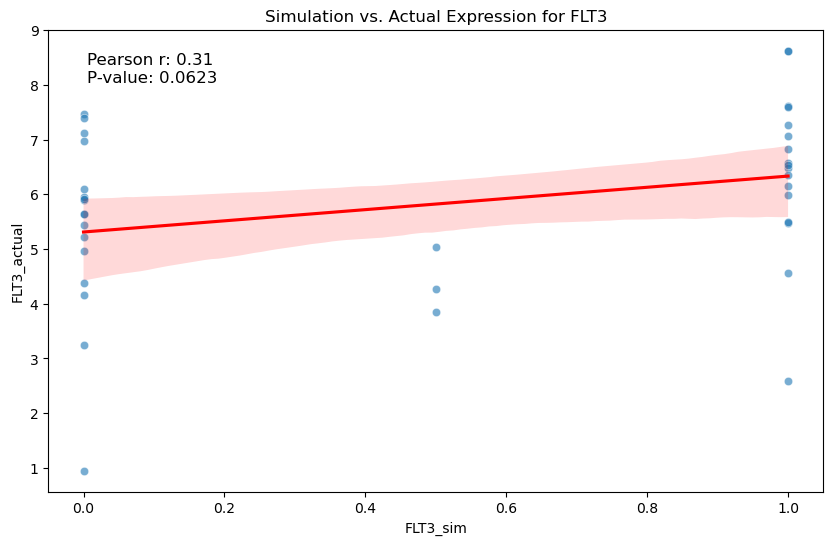

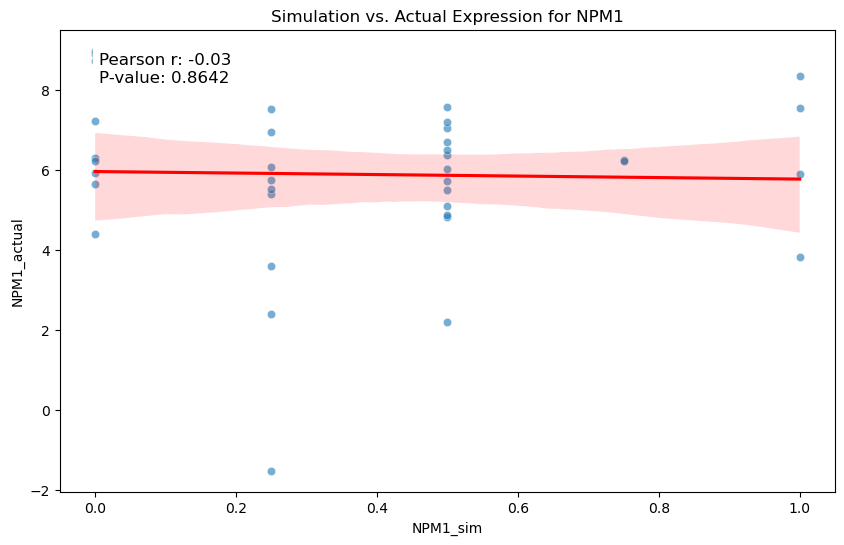

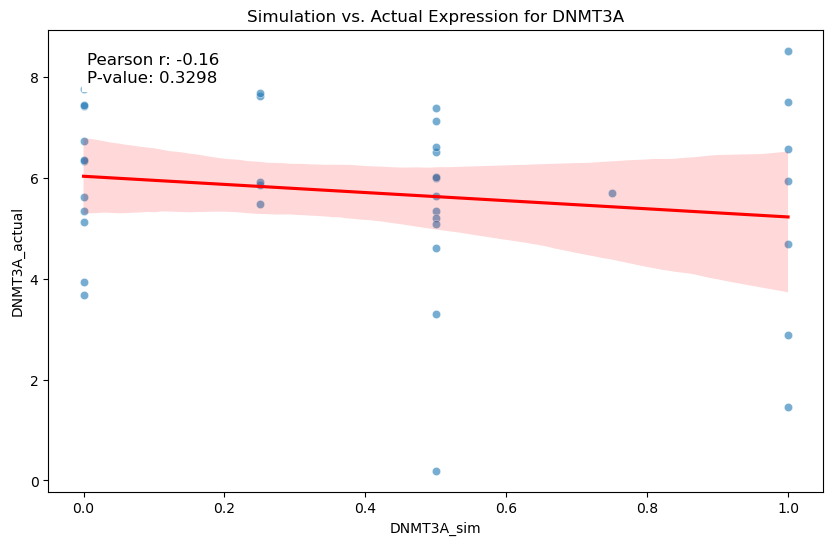

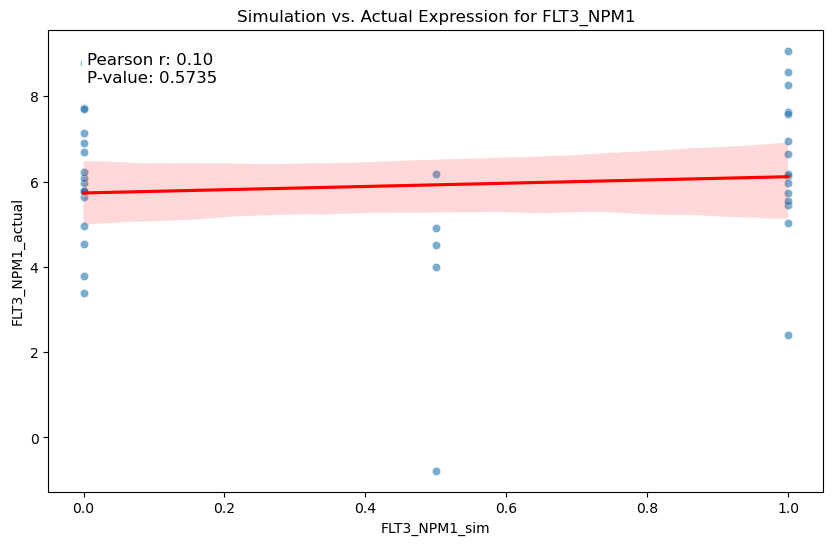

In [12]:
compare_simulation_with_expression(simulation_results_or, expression, mapping_results)

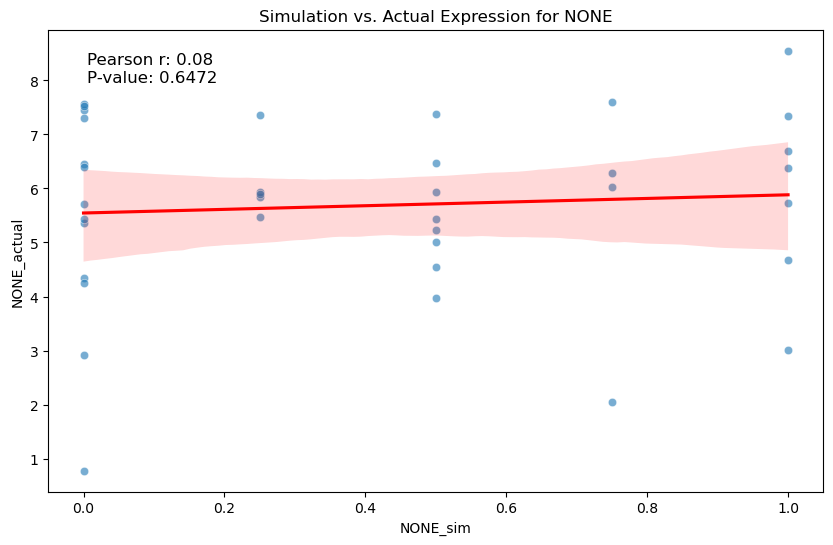

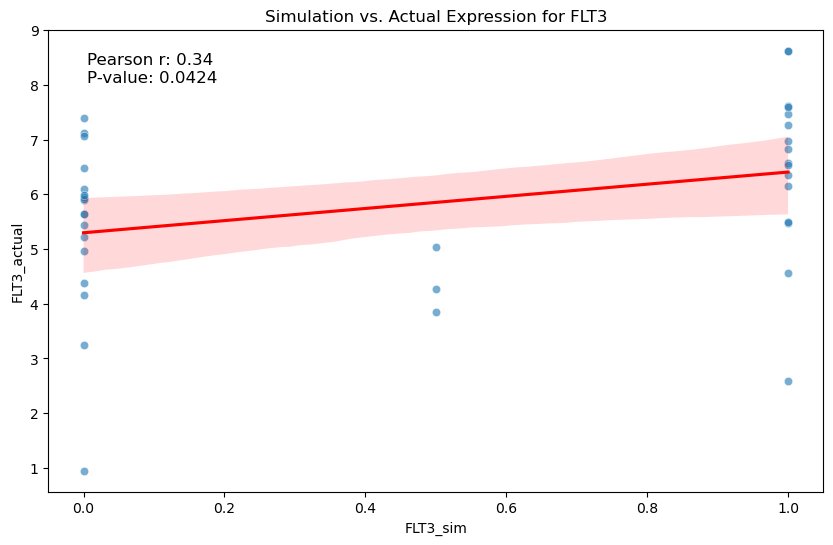

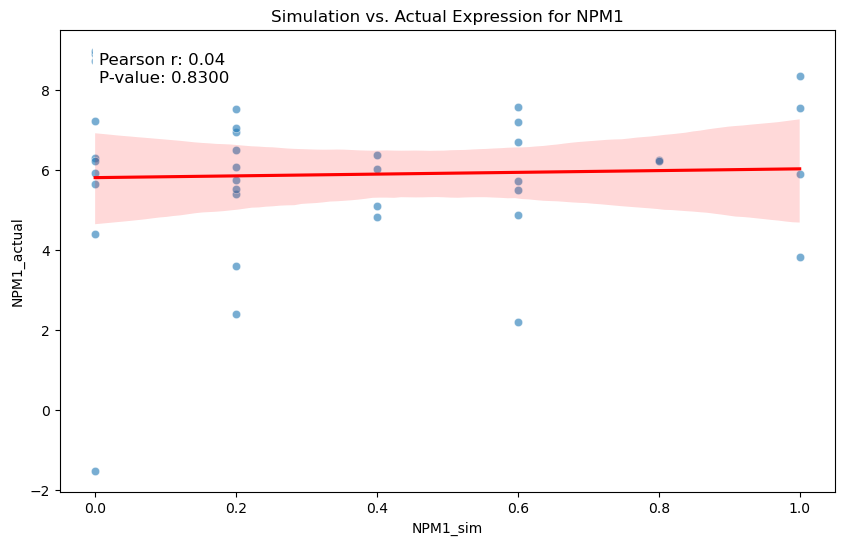

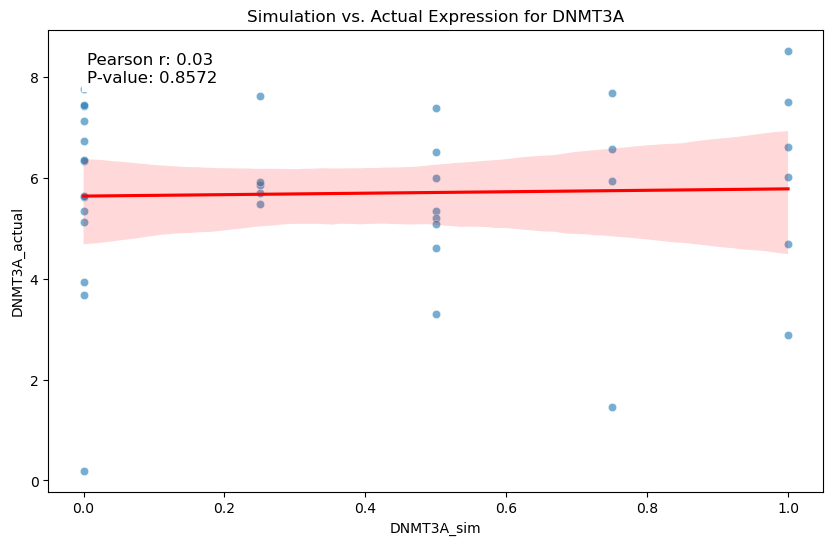

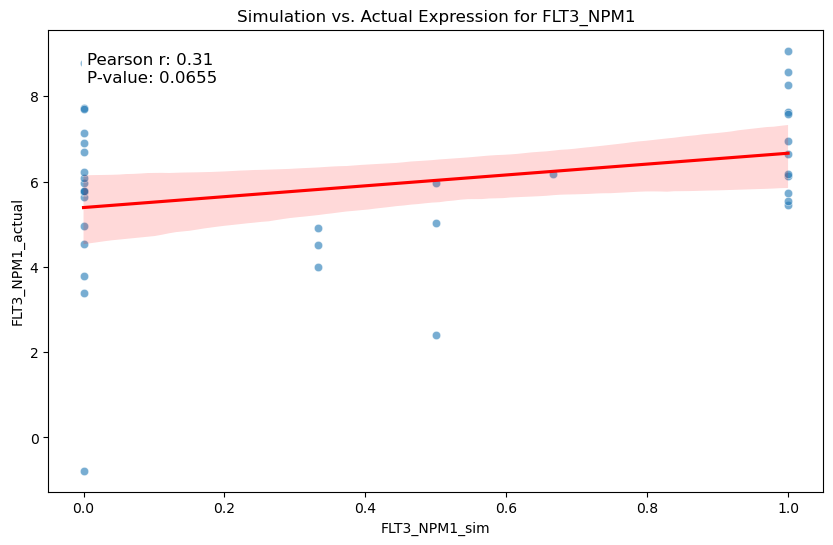

In [9]:
compare_simulation_with_expression(simulation_results_inhibitor_wins, expression, mapping_results)

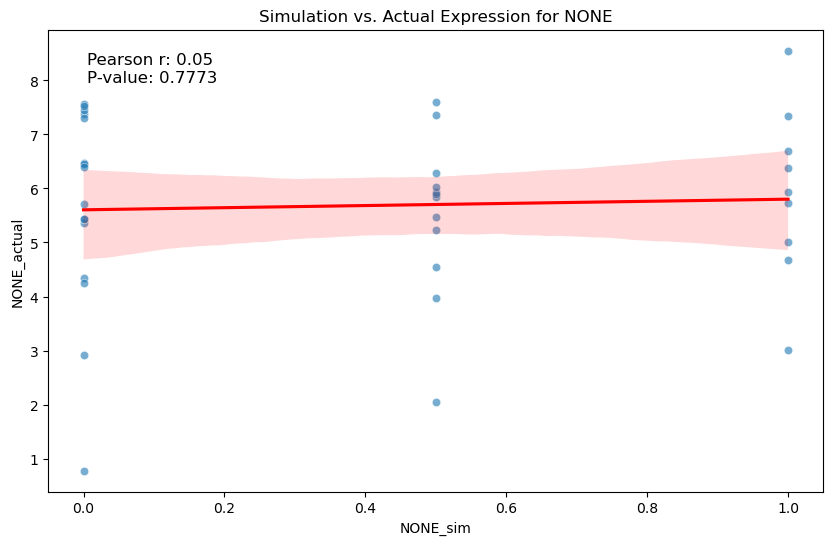

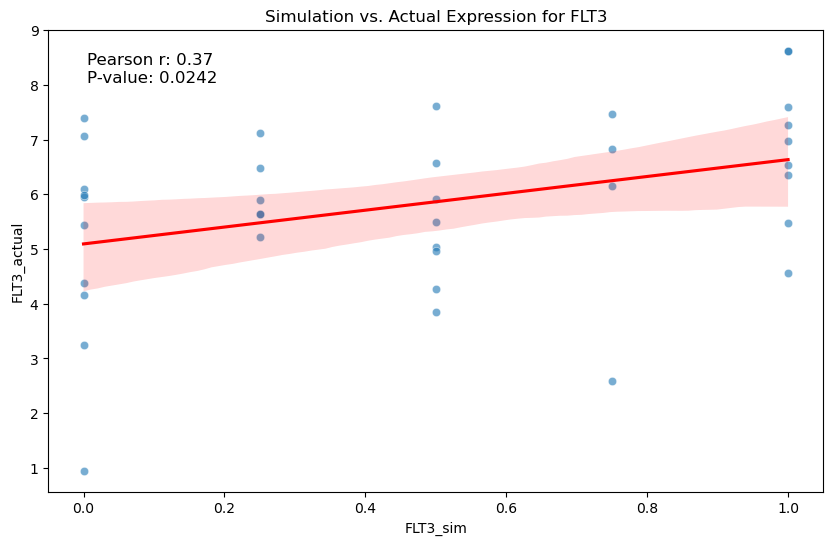

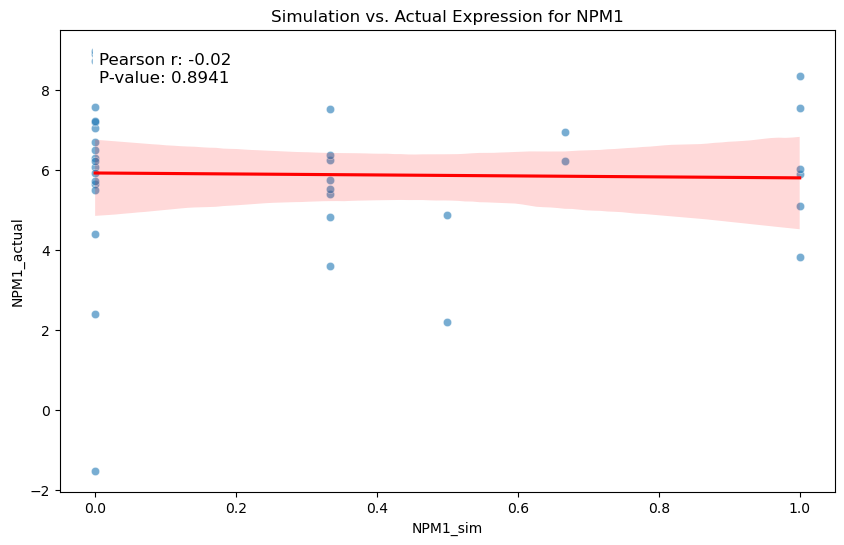

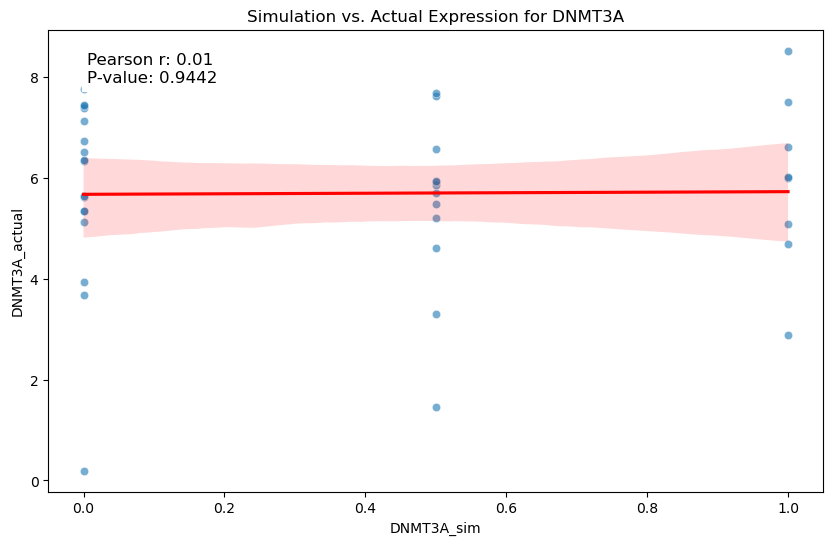

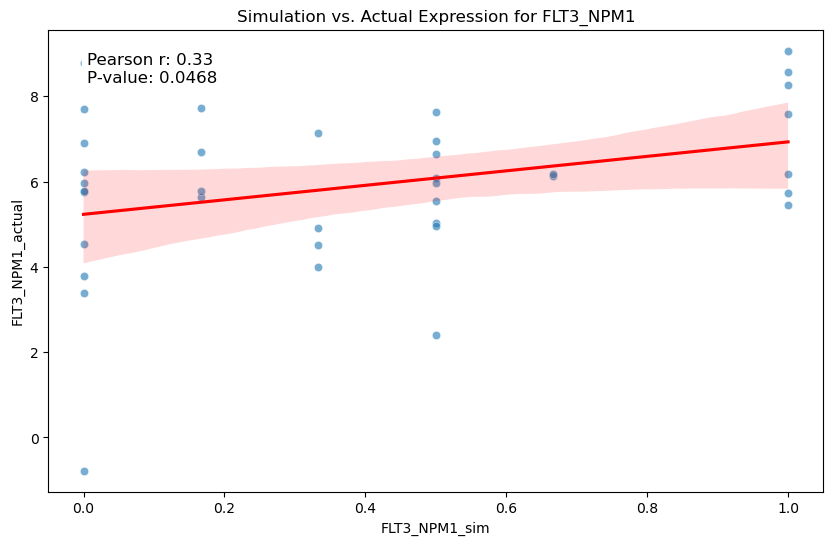

In [13]:
compare_simulation_with_expression(simulation_results_and, expression, mapping_results)

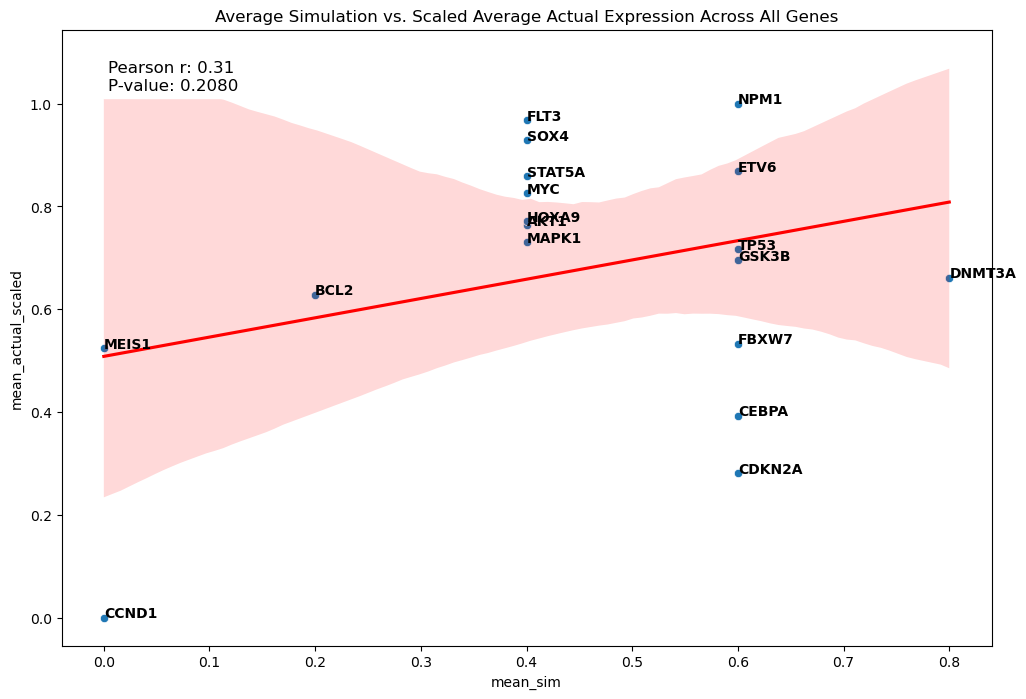

In [14]:
def compare_simulation_with_all_genes(simulation_df, expression_df, results_mapping):
    # Convert all data in simulation_df to numeric
    simulation_df = simulation_df.apply(pd.to_numeric, errors='coerce')

    # Reshape expression_df to long format
    expression_long = expression_df.melt(id_vars=['display_label'], var_name='sample', value_name='expression')

    # Create a mapping of sample to condition from results_mapping
    sample_to_condition = {}
    for condition, samples in results_mapping.items():
        for sample in samples:
            sample_to_condition[sample] = condition

    # Map samples to conditions in expression_long
    expression_long['condition'] = expression_long['sample'].map(sample_to_condition)

    # Drop rows where condition is NaN (samples that don't map to any condition)
    expression_long.dropna(subset=['condition'], inplace=True)

    # Aggregate expression data by gene and condition
    average_expression = expression_long.groupby(['display_label', 'condition']).expression.mean().unstack()

    # Merge with simulation data (simulation data has conditions as columns and genes as index)
    # Use suffixes to differentiate between simulation and actual data
    combined_data = simulation_df.join(average_expression, how='inner', lsuffix='_sim', rsuffix='_actual')

    # Calculate mean expression across all conditions for simulation and actual data
    combined_data['mean_sim'] = combined_data.filter(regex='_sim$').mean(axis=1)
    combined_data['mean_actual'] = combined_data.filter(regex='_actual$').mean(axis=1)

    # Convert to float and drop NaN and inf values
    combined_data = combined_data[['mean_sim', 'mean_actual']].apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan).dropna()

    # Scale actual expression values from 0 to 1
    scaler = MinMaxScaler()
    combined_data['mean_actual_scaled'] = scaler.fit_transform(combined_data[['mean_actual']])

    # Plotting
    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(x='mean_sim', y='mean_actual_scaled', data=combined_data)
    plt.title("Average Simulation vs. Scaled Average Actual Expression Across All Genes")
    plt.xlabel('Average Simulated Expression')
    plt.ylabel('Scaled Average Actual Expression')

    # Annotate gene names
    for i, row in combined_data.iterrows():
        ax.text(row['mean_sim'], row['mean_actual_scaled'], i, horizontalalignment='left', size='medium', color='black', weight='semibold')

    # Fit linear regression and calculate Pearson correlation
    if not combined_data.empty:
        coef, p_value = pearsonr(combined_data['mean_sim'], combined_data['mean_actual_scaled'])
        sns.regplot(x='mean_sim', y='mean_actual_scaled', data=combined_data, scatter=False, color='red')
        plt.annotate(f'Pearson r: {coef:.2f}\nP-value: {p_value:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='top', fontsize=12, backgroundcolor='white')
    plt.show()

compare_simulation_with_all_genes(simulation_results_1, expression, mapping_results)


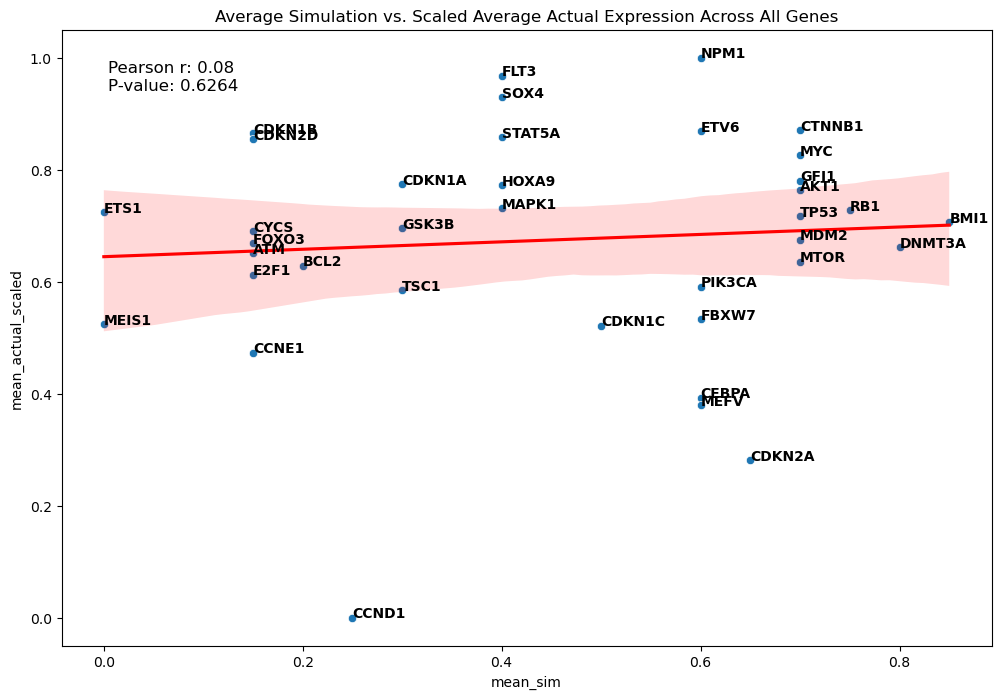

In [16]:
compare_simulation_with_all_genes(simulation_results_or, expression, mapping_results)

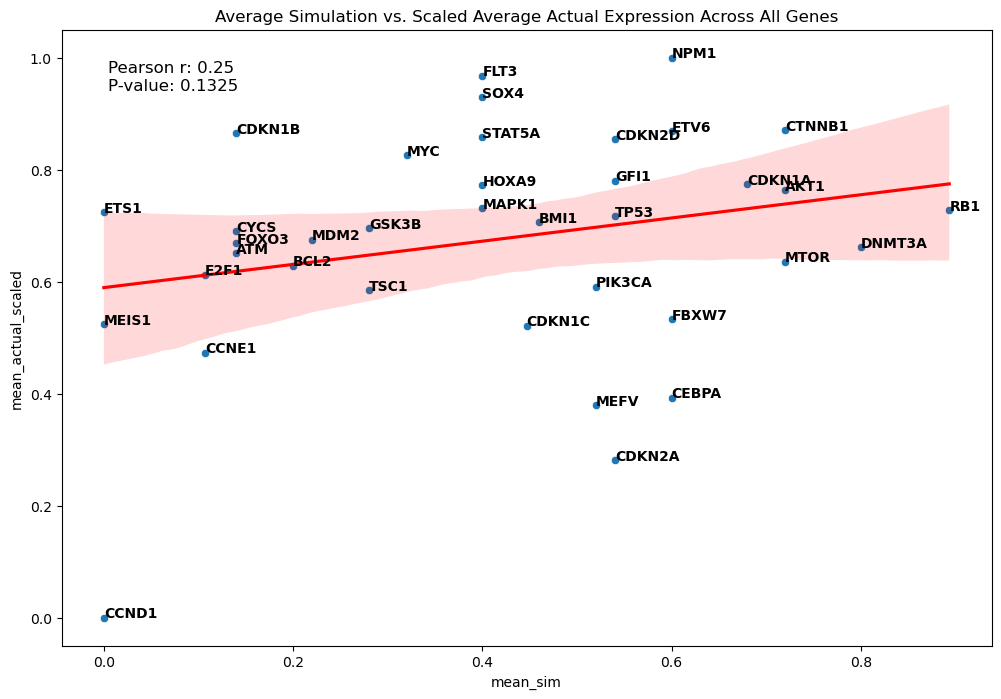

In [15]:
compare_simulation_with_all_genes(simulation_results_inhibitor_wins, expression, mapping_results)

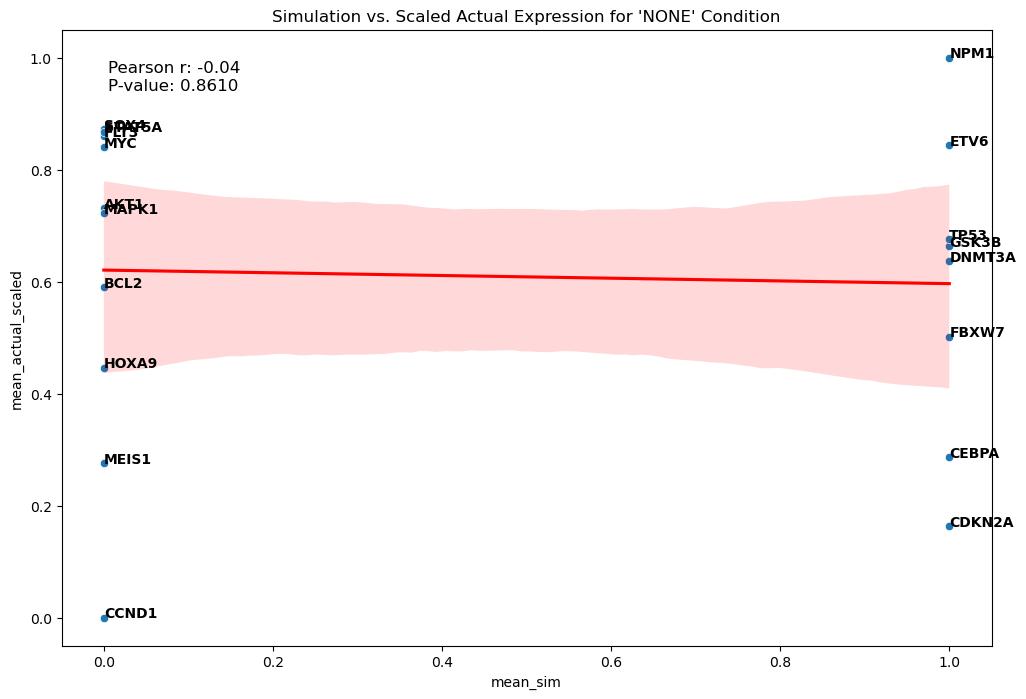

In [17]:
def compare_simulation_with_none_condition(simulation_df, expression_df, results_mapping):
    # Convert all data in simulation_df to numeric, coercing errors
    simulation_df = simulation_df.apply(pd.to_numeric, errors='coerce')

    # Reshape expression_df to long format
    expression_long = expression_df.melt(id_vars=['display_label'], var_name='sample', value_name='expression')

    # Create a mapping of sample to condition from results_mapping
    sample_to_condition = {}
    for condition, samples in results_mapping.items():
        for sample in samples:
            sample_to_condition[sample] = condition

    # Map samples to conditions in expression_long
    expression_long['condition'] = expression_long['sample'].map(sample_to_condition)

    # Drop rows where condition is NaN (samples that don't map to any condition)
    expression_long.dropna(subset=['condition'], inplace=True)

    # Filter for the 'NONE' condition only
    none_expression = expression_long[expression_long['condition'] == 'NONE']

    # Aggregate expression data by gene
    average_expression = none_expression.groupby(['display_label']).expression.mean()

    # Prepare simulation data for the 'NONE' condition
    simulation_none = simulation_df['NONE']

    # Combine the data
    combined_data = pd.DataFrame({
        'mean_sim': simulation_none,
        'mean_actual': average_expression
    }).dropna()

    # Convert to float and drop NaN and inf values
    combined_data = combined_data.apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan).dropna()

    # Scale actual expression values from 0 to 1
    scaler = MinMaxScaler()
    combined_data['mean_actual_scaled'] = scaler.fit_transform(combined_data[['mean_actual']])

    # Plotting
    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(x='mean_sim', y='mean_actual_scaled', data=combined_data)
    plt.title("Simulation vs. Scaled Actual Expression for 'NONE' Condition")
    plt.xlabel('Simulated Expression')
    plt.ylabel('Scaled Actual Expression')

    # Annotate gene names
    for i, row in combined_data.iterrows():
        ax.text(row['mean_sim'], row['mean_actual_scaled'], i, horizontalalignment='left', size='medium', color='black', weight='semibold')

    # Fit linear regression and calculate Pearson correlation
    if not combined_data.empty:
        coef, p_value = pearsonr(combined_data['mean_sim'], combined_data['mean_actual_scaled'])
        sns.regplot(x='mean_sim', y='mean_actual_scaled', data=combined_data, scatter=False, color='red')
        plt.annotate(f'Pearson r: {coef:.2f}\nP-value: {p_value:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='top', fontsize=12, backgroundcolor='white')
    plt.show()

compare_simulation_with_none_condition(simulation_results_1, expression, mapping_results)

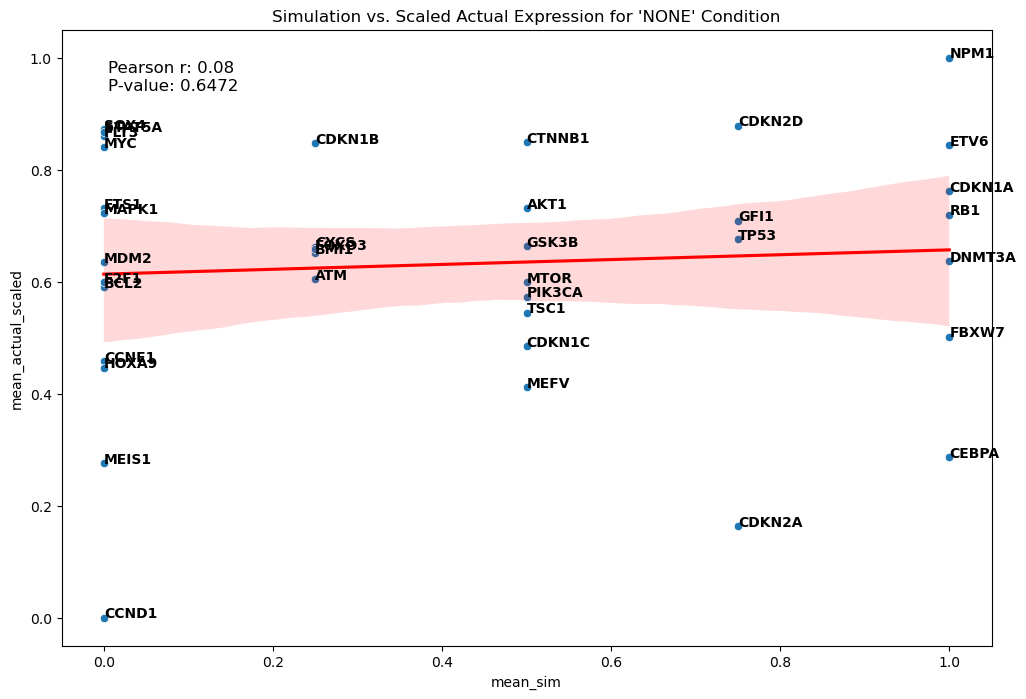

In [19]:
compare_simulation_with_none_condition(simulation_results_inhibitor_wins, expression, mapping_results)